In [1]:
import arch_2 as arch # This is the model architecture to use
SEED = arch.SEED # Use same random seed for consistency
import utils

import os
import h5py

import tensorflow as tf
import numpy as np
np.random.seed(SEED)
from tqdm import tqdm, tnrange, tqdm_notebook
import matplotlib.pyplot as plt
%matplotlib inline

# Data Processing

In [2]:
# Maybe get the data .mat file
if not os.path.isfile("data.mat"):
    !wget https://www.dropbox.com/s/b1bnrj2f30xe1ns/xq_data_big.mat?dl=0
    !mv 'xq_data_big.mat?dl=0' data.mat

In [4]:
# Import the data from file
f = h5py.File("data.mat")
data, labels = np.array(f['data']), np.array(f['labels'])

f.close()

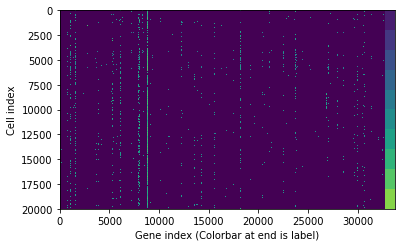

In [13]:
# Visualize data with labels
plt.imshow(np.hstack((data, np.repeat(labels, 1000, axis=1))))
plt.xlabel("Gene index (Colorbar at end is label)")
plt.ylabel("Cell index");

In [5]:
# Mix up our data
inds = np.arange(data.shape[0])
np.random.shuffle(inds)
data = data[inds]
labels = labels[inds]

In [6]:
# Parameters to use for the rest of this workflow
BATCH_SIZE = 60
TEST_SIZE = 3000
NCLASS = 10

In [7]:
(train_data, train_labels, test_data, test_labels) = data[TEST_SIZE:], labels[TEST_SIZE:], data[:TEST_SIZE], labels[:TEST_SIZE]

# Convert labels to one-hot format
train_labels = (np.arange(NCLASS) == train_labels).astype(np.float32)
test_labels = (np.arange(NCLASS) == test_labels).astype(np.float32)

[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


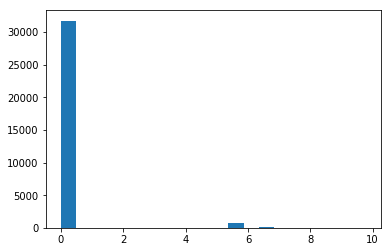

In [8]:
# Sanity check to make sure data is not crazy
plt.subplot(111).hist(train_data[0].flatten(), bins=20)
print(train_labels[0])

In [9]:
# Extract validation set from data
VAL_SIZE = int(train_data.shape[0] * 0.1)
val_data, train_data = train_data[:VAL_SIZE], train_data[VAL_SIZE:]
val_labels, train_labels = train_labels[:VAL_SIZE], train_labels[VAL_SIZE:]

In [10]:
train_data.shape

(15300, 32738)

In [11]:
# Reshape data to the format specified by the particular architecture we are using
train_data = arch.reshape_data(train_data)
test_data = arch.reshape_data(test_data)
val_data = arch.reshape_data(val_data)

In [12]:
train_data.shape

(15300, 32738, 1, 1)

# Defining computation graph

### Variables and input / output nodes

In [13]:
arch.make_vars_on_cpu(NCLASS)
train_data_node = tf.placeholder(tf.float32, [BATCH_SIZE] + list(train_data.shape[1:]))
train_label_node = tf.placeholder(tf.float32, [BATCH_SIZE, NCLASS])         
test_data_node, test_label_node = tf.constant(test_data, dtype=tf.float32), tf.constant(test_labels, dtype=tf.float32)
val_data_node, val_label_node = tf.constant(val_data, dtype=tf.float32), tf.constant(val_labels, dtype=tf.float32)

Instructions for updating:
Colocations handled automatically by placer.


### Losses, learning rate, and optimization step

In [14]:
val_out = arch.model(val_data_node)
val_probs = tf.nn.softmax(val_out)

test_out = arch.model(test_data_node)
test_probs = tf.nn.softmax(test_out)

logits, regularizers = arch.model(train_data_node, train=True)
probs = tf.nn.softmax(logits)
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=train_label_node))
loss += regularizers

global_step = tf.Variable(0, trainable=False)
start_eta = 0.01
learning_rate = tf.train.exponential_decay(start_eta, global_step * BATCH_SIZE, train_labels.shape[0], 0.95, staircase=True)
update_weights = tf.train.MomentumOptimizer(learning_rate=learning_rate, momentum=0.9).minimize(loss, global_step=global_step)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



# Training

In [15]:
sess = tf.InteractiveSession()
sess.as_default()
tf.global_variables_initializer().run()

### Sanity check, ensure that things are working

Initial mini-batch err: 91.66666666666666


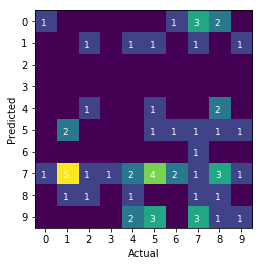

In [16]:
dat, lab = train_data[:BATCH_SIZE], train_labels[:BATCH_SIZE]

feed_dict = {train_data_node:dat, train_label_node:lab }
predictions, l = sess.run([probs, loss], feed_dict)

err, confusions = utils.error_rate(predictions, lab), utils.confusions(predictions, lab)
print(f"Initial mini-batch err: {err}")
utils.plot_confusions(confusions);

### Actual training

In [17]:
# Train over the first 1/4th of our training set.
n_epoch = 1
steps = (train_labels.shape[0] // BATCH_SIZE) * n_epoch
ls = np.empty(steps)
errs = np.empty(steps)
val_errs = np.empty(np.ceil(steps / 100).astype(int))

for step in tnrange(steps):
    # Compute the offset of the current minibatch in the data.
    offset = (step * BATCH_SIZE) % (train_labels.shape[0] - BATCH_SIZE) # Should really randomize some
    batch_data = train_data[offset:(offset + BATCH_SIZE), :, :, :]
    batch_labels = train_labels[offset:(offset + BATCH_SIZE)]
    feed_dict = {train_data_node: batch_data,
                 train_label_node: batch_labels}
    # Run the graph and fetch some of the nodes.
    _, l, predictions = sess.run(
      [update_weights, loss, probs],
      feed_dict=feed_dict)
    ls[step] = l
    errs[step] = utils.error_rate(predictions, batch_labels)
    
    if step % 100 == 0:
        val_errs[step // 100] = utils.error_rate(val_out.eval(), val_labels)
        #print('Step %d of %d' % (step, steps))
        #print("Mini-batch loss: {}, error: {}, val error: {}".format(ls[step], errs[step], val_errs[step // 100]))

KeyboardInterrupt: 

# Evaluation

### Performance on test set

In [ ]:
predicted, actual = test_probs.eval(), test_label_node.eval()
error = utils.error_rate(predicted, actual)
confusions = utils.confusions(predicted, actual)
print(f"Test error: {error}")
utils.plot_confusions(confusions);

### Learning curves

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].plot(ls)
ax[0].set_xlabel("Training Step")
ax[0].set_ylabel("Loss (cross-entropy)")

ax[1].plot(errs, label="Training Error")
ax[1].scatter(np.arange(val_errs.shape[0]) * 100, val_errs, label="Validation Error", c='k')
ax[1].set_xlabel("Training Step")
ax[1].set_ylabel("Error rate (\%)")
ax[1].legend();

In [ ]:
dat, lab = train_data[:BATCH_SIZE], train_labels[:BATCH_SIZE]

feed_dict = {train_data_node:dat, train_label_node:lab }
predictions, l = sess.run([probs, loss], feed_dict)

err, confusions = utils.error_rate(predictions, lab), utils.confusions(predictions, lab)
print(f"Initial mini-batch err: {err}")
utils.plot_confusions(confusions);

In [ ]:
t_dat = test_data.reshape(test_data.shape[:2])
tr_dat = train_data.reshape(train_data.shape[:2])
v_dat = val_data.reshape(val_data.shape[:2])

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(12, 5))
ax[0].imshow(tr_dat)
ax[1].imshow(t_dat)
ax[2].imshow(v_dat)